In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import streamlit as st
from datetime import datetime

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load the data
print("Loading metadata.csv...")
df = pd.read_csv('metadata.csv')

# Examine first few rows
print("First 5 rows of the dataset:")
print(df.head())

print("\nData structure:")
print(df.info())

# Check DataFrame dimensions
print(f"\nDataset dimensions: {df.shape[0]} rows, {df.shape[1]} columns")

# Check data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values in each column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Basic statistics for numerical columns
print("\nBasic statistics for numerical columns:")
print(df.describe())

Loading metadata.csv...
First 5 rows of the dataset:
   cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid  pubmed_id license  \
0  PMC35282   11472636   no-cc   
1  PMC5

In [3]:
# Create a copy for cleaning
df_clean = df.copy()

# Identify columns with many missing values
missing_percentage = (df_clean.isnull().sum() / len(df_clean)) * 100
print("Columns with more than 50% missing values:")
print(missing_percentage[missing_percentage > 50])

# Handle missing values
print(f"Original shape: {df_clean.shape}")

# Drop rows where title is missing
df_clean = df_clean.dropna(subset=['title'])
print(f"After dropping rows with missing titles: {df_clean.shape}")

# Fill missing abstract with empty string
df_clean['abstract'] = df_clean['abstract'].fillna('')

# Convert publish_time to datetime and extract year
df_clean['publish_time'] = pd.to_datetime(df_clean['publish_time'], errors='coerce')
df_clean['year'] = df_clean['publish_time'].dt.year

# Create new columns
df_clean['abstract_word_count'] = df_clean['abstract'].apply(lambda x: len(str(x).split()))
df_clean['title_word_count'] = df_clean['title'].apply(lambda x: len(str(x).split()))

print("\nCleaned dataset info:")
print(df_clean.info())
print(f"Missing values in key columns:")
print(df_clean[['title', 'abstract', 'year', 'journal']].isnull().sum())

Columns with more than 50% missing values:
mag_id              100.0
who_covidence_id    100.0
arxiv_id            100.0
s2_id               100.0
dtype: float64
Original shape: (100, 19)
After dropping rows with missing titles: (100, 19)

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cord_uid             100 non-null    object        
 1   sha                  94 non-null     object        
 2   source_x             100 non-null    object        
 3   title                100 non-null    object        
 4   doi                  100 non-null    object        
 5   pmcid                100 non-null    object        
 6   pubmed_id            100 non-null    int64         
 7   license              100 non-null    object        
 8   abstract             100 non-null    object        
 9   pu

Papers by publication year:
year
1997     1
2000     5
2001     7
2002     1
2003     4
2004    10
2005    23
2006    36
2007    13
Name: count, dtype: int64

Top 10 journals:
journal
Nucleic Acids Res     16
Respir Res             8
BMC Public Health      8
PLoS One               7
J Gen Intern Med       6
Crit Care              6
The EMBO Journal       3
PLoS Comput Biol       2
Virol J                2
BMC Bioinformatics     2
Name: count, dtype: int64

Top 20 words in titles:
of: 68
in: 41
the: 33
and: 30
a: 24
for: 17
to: 16
an: 10
rna: 9
virus: 9
public: 8
health: 8
by: 8
infection: 7
influenza: 7
human: 7
from: 6
using: 6
role: 5
on: 5


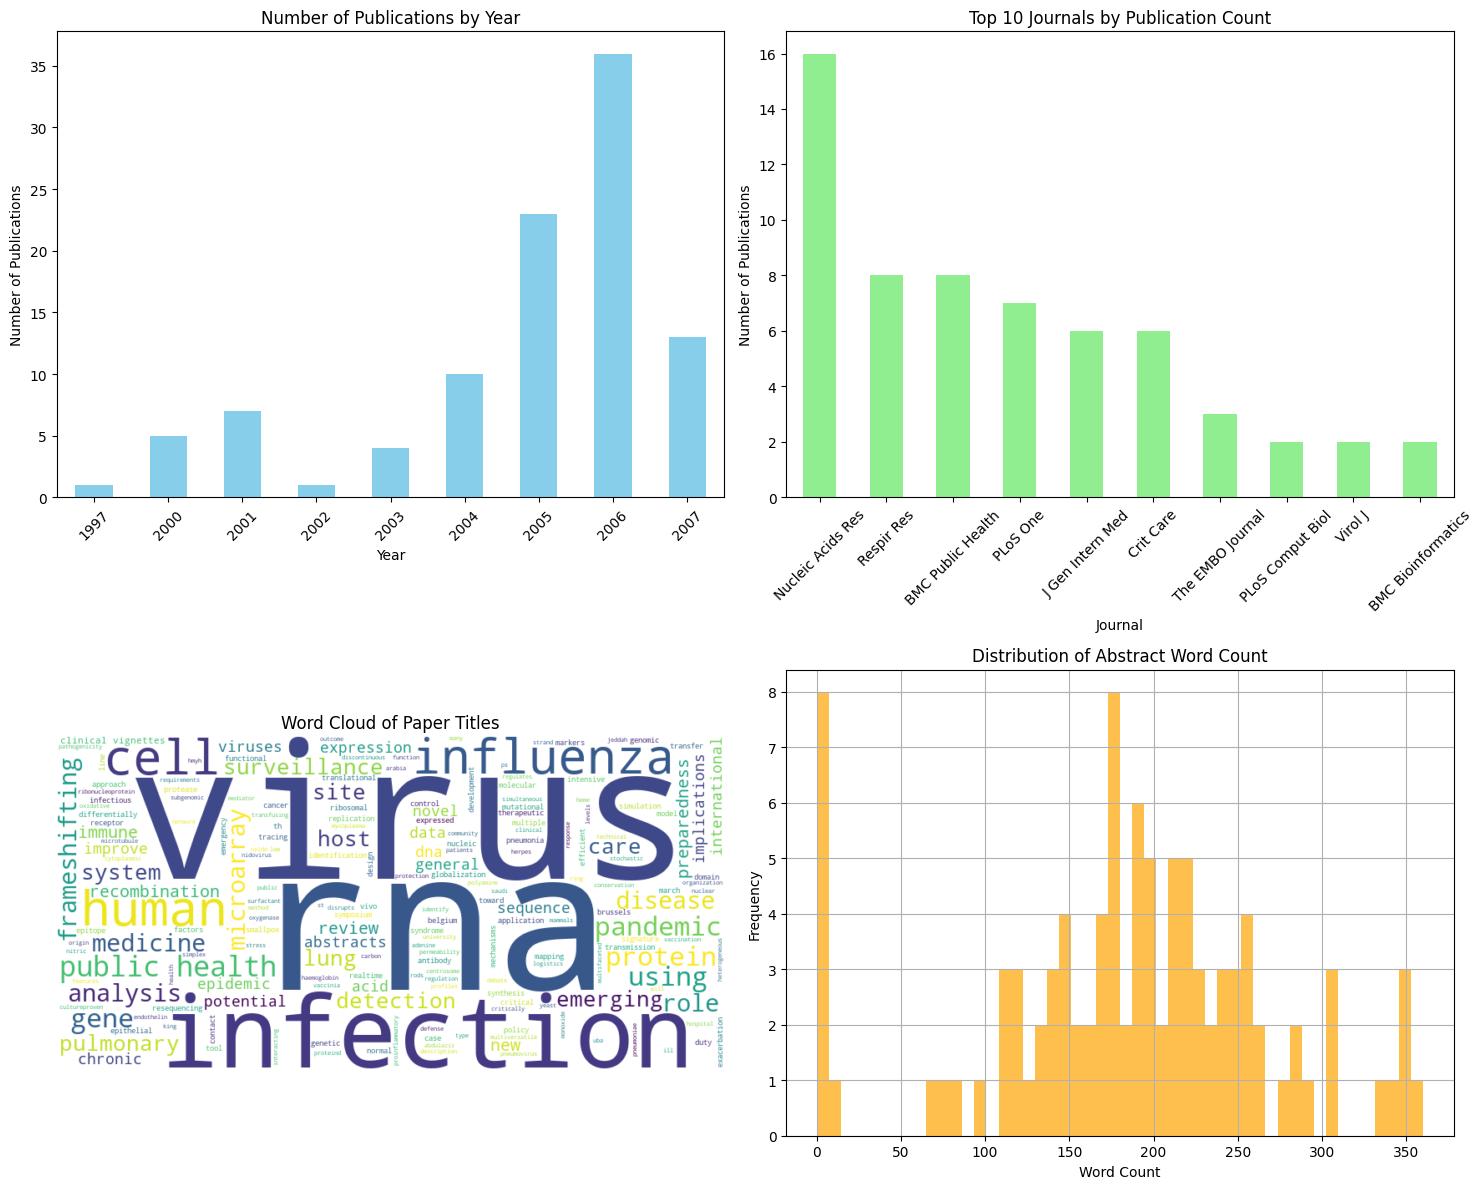


Top 10 sources:
source_x
PMC    100
Name: count, dtype: int64

Cleaned data saved to 'cleaned_metadata.csv'


In [4]:
# Count papers by publication year
year_counts = df_clean['year'].value_counts().sort_index()
print("Papers by publication year:")
print(year_counts)

# Identify top journals
top_journals = df_clean['journal'].value_counts().head(10)
print("\nTop 10 journals:")
print(top_journals)

# Most frequent words in titles
def clean_text(text):
    """Clean text by removing special characters and converting to lowercase"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    return text

# Get all titles and clean them
all_titles = ' '.join(df_clean['title'].dropna().apply(clean_text))
title_words = all_titles.split()
word_freq = Counter(title_words).most_common(20)

print("\nTop 20 words in titles:")
for word, count in word_freq:
    print(f"{word}: {count}")

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Publications over time
year_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Number of Publications by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Publications')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Top journals
top_journals.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Top 10 Journals by Publication Count')
ax2.set_xlabel('Journal')
ax2.set_ylabel('Number of Publications')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Word cloud of titles
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)
ax3.imshow(wordcloud, interpolation='bilinear')
ax3.set_title('Word Cloud of Paper Titles')
ax3.axis('off')

# Plot 4: Distribution of abstract word count
df_clean['abstract_word_count'].hist(bins=50, ax=ax4, color='orange', alpha=0.7)
ax4.set_title('Distribution of Abstract Word Count')
ax4.set_xlabel('Word Count')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('cord19_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis: Papers by source
source_counts = df_clean['source_x'].value_counts().head(10)
print("\nTop 10 sources:")
print(source_counts)

# Save cleaned data for Streamlit app
df_clean.to_csv('cleaned_metadata.csv', index=False)
print("\nCleaned data saved to 'cleaned_metadata.csv'")